SimSiam ResNet PreTrain

In [2]:
%%writefile simsiam_model.py
import torch
import torch.nn as nn
import torchvision.models as models

class MLPHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=2048, out_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim, bias=False),
            nn.BatchNorm1d(out_dim, affine=False)
        )
    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=512, out_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class SimSiam(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projector = MLPHead(2048)
        self.predictor = PredictionHead()
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                m.requires_grad_(False)

    def _forward_backbone(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)

    def forward(self, x1, x2):
        z1 = self.projector(self._forward_backbone(x1))
        z2 = self.projector(self._forward_backbone(x2))
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)
        return p1, p2, z1.detach(), z2.detach()

    def __repr__(self):
        return f"SimSiam(backbone=ResNet50, projector={self.projector}, predictor={self.predictor})" 

Overwriting simsiam_model.py


In [4]:
 %%writefile simsiam_pretrain.py
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from simsiam_model import SimSiam

class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if os.path.isfile(os.path.join(root_dir, fname)) and fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        if len(self.filepaths) == 0:
            raise RuntimeError(f"No images found in {root_dir}")
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert('RGB')
        if self.transform:
            view1 = self.transform(img)
            view2 = self.transform(img)
            return view1, view2
        else:
            return img, img

def negative_cosine_similarity(p, z):
    p = torch.nn.functional.normalize(p, dim=1)
    z = torch.nn.functional.normalize(z, dim=1)
    return -(p * z).sum(dim=1).mean()

def pretrain(
    root_path="/kaggle/input/minida/mini_output1/pretrain",
    checkpoint_dir="/kaggle/working/",
    epochs=150,
    batch_size=64
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "logs"))

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

    dataset = UnlabeledDataset(root_dir=root_path, transform=train_transform)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )

    model = SimSiam().to(device)
    base_lr = 0.05 * batch_size / 256
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    checkpoint_path = os.path.join(checkpoint_dir, "simsiam_checkpoint.pth")
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.backbone.load_state_dict(checkpoint['backbone'])
        model.projector.load_state_dict(checkpoint['projector'])
        model.predictor.load_state_dict(checkpoint['predictor'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch'] + 1

    print(f"Starting SimSiam pretraining for {epochs} epochs...")

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0.0
        for batch_idx, (x1, x2) in enumerate(dataloader):
            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)
            p1, p2, z1, z2 = model(x1, x2)
            loss = 0.5 * (negative_cosine_similarity(p1, z2) + negative_cosine_similarity(p2, z1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        writer.add_scalar("Loss/train", avg_loss, epoch)
        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'backbone': model.backbone.state_dict(),
                'projector': model.projector.state_dict(),
                'predictor': model.predictor.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }, checkpoint_path)

    torch.save({
        'backbone': model.backbone.state_dict(),
        'projector': model.projector.state_dict(),
        'predictor': model.predictor.state_dict()
    }, os.path.join(checkpoint_dir, "simsiam_pretrained.pth"))
    print("Pretraining complete! Model saved to", os.path.join(checkpoint_dir, "simsiam_pretrained.pth"))

if __name__ == "__main__":
    pretrain()                  

Overwriting simsiam_pretrain.py


In [5]:
!python simsiam_pretrain.py

2025-07-05 20:48:57.026027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751748537.227460     338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751748537.289623     338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Starting SimSiam pretraining for 150 epochs...
Epoch [1/150] Batch [0] Loss: -0.0016
Epoch [1/150] Average Loss: -0.0099
Epoch [2/150] Batch [0] Loss: -0.0135
Epoch [2/150] Average Loss: -0.0284
Epoch [3/150] Batch [0] Loss: -0.0292
Epoch [3/150] Average Loss: -0.0444
Epoch [4/150] Batch [0] Loss: -0.0753
Epoch [4/150] Average Loss: -0.0815
Epoch [5/150] Batch [0] Loss: -0.1145
Epoch [5/150] Average Loss: -0.1373
E

FineTune SimSiam Resnet


Epoch 1/25


Train Loss: 1.1210, Acc: 0.3870 | Val Loss: 0.9577, Acc: 0.6162
Validation accuracy improved, saving model.

Epoch 2/25


Train Loss: 1.0841, Acc: 0.4134 | Val Loss: 1.4521, Acc: 0.7071
Validation accuracy improved, saving model.

Epoch 3/25


Train Loss: 1.0019, Acc: 0.5105 | Val Loss: 1.2403, Acc: 0.6061
EarlyStopping counter: 1 / 7

Epoch 4/25


Train Loss: 0.9395, Acc: 0.5521 | Val Loss: 0.7087, Acc: 0.8182
Validation accuracy improved, saving model.

Epoch 5/25


Train Loss: 0.9791, Acc: 0.5596 | Val Loss: 0.8092, Acc: 0.6465
EarlyStopping counter: 1 / 7

Epoch 6/25


Train Loss: 0.8941, Acc: 0.6241 | Val Loss: 0.7275, Acc: 0.7576
EarlyStopping counter: 2 / 7

Epoch 7/25


Train Loss: 0.8907, Acc: 0.6009 | Val Loss: 0.5825, Acc: 0.7475
EarlyStopping counter: 3 / 7

Epoch 8/25


Train Loss: 0.8968, Acc: 0.5906 | Val Loss: 0.5862, Acc: 0.7778
EarlyStopping counter: 4 / 7

Epoch 9/25


Train Loss: 0.8427, Acc: 0.6493 | Val Loss: 0.4738, Acc: 0.8586
Validation accuracy improved, saving model.

Epoch 10/25


Train Loss: 0.8826, Acc: 0.6224 | Val Loss: 0.5190, Acc: 0.8788
Validation accuracy improved, saving model.

Epoch 11/25


Train Loss: 0.8319, Acc: 0.6588 | Val Loss: 0.5646, Acc: 0.8283
EarlyStopping counter: 1 / 7

Epoch 12/25


Train Loss: 0.8045, Acc: 0.6708 | Val Loss: 0.4469, Acc: 0.8586
EarlyStopping counter: 2 / 7

Epoch 13/25


Train Loss: 0.8108, Acc: 0.6702 | Val Loss: 0.5361, Acc: 0.8283
EarlyStopping counter: 3 / 7

Epoch 14/25


Train Loss: 0.8321, Acc: 0.6540 | Val Loss: 0.5014, Acc: 0.8384
EarlyStopping counter: 4 / 7

Epoch 15/25


Train Loss: 0.8787, Acc: 0.6346 | Val Loss: 0.4580, Acc: 0.8788
EarlyStopping counter: 5 / 7

Epoch 16/25


Train Loss: 0.8573, Acc: 0.6508 | Val Loss: 0.4449, Acc: 0.8687
EarlyStopping counter: 6 / 7

Epoch 17/25


Train Loss: 0.8387, Acc: 0.6503 | Val Loss: 0.4137, Acc: 0.8889
Validation accuracy improved, saving model.

Epoch 18/25


Train Loss: 0.8239, Acc: 0.6452 | Val Loss: 0.4635, Acc: 0.8586
EarlyStopping counter: 1 / 7

Epoch 19/25


Train Loss: 0.8061, Acc: 0.6692 | Val Loss: 0.4592, Acc: 0.8586
EarlyStopping counter: 2 / 7

Epoch 20/25


Train Loss: 0.7450, Acc: 0.7052 | Val Loss: 0.4199, Acc: 0.8687
EarlyStopping counter: 3 / 7

Epoch 21/25


Train Loss: 0.8431, Acc: 0.6602 | Val Loss: 0.4036, Acc: 0.8788
EarlyStopping counter: 4 / 7

Epoch 22/25


Train Loss: 0.8319, Acc: 0.6274 | Val Loss: 0.4150, Acc: 0.8788
EarlyStopping counter: 5 / 7

Epoch 23/25


Train Loss: 0.8679, Acc: 0.6110 | Val Loss: 0.4144, Acc: 0.8687
EarlyStopping counter: 6 / 7

Epoch 24/25


Train Loss: 0.7923, Acc: 0.6845 | Val Loss: 0.3956, Acc: 0.8990
Validation accuracy improved, saving model.

Epoch 25/25


Train Loss: 0.8174, Acc: 0.6403 | Val Loss: 0.4109, Acc: 0.8889
EarlyStopping counter: 1 / 7

Test set results:


Test Loss: 0.3199, Test Acc: 0.9495
              precision    recall  f1-score   support

  Alternaria       1.00      0.86      0.93        37
Healthy Leaf       0.86      1.00      0.93        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.95        99
   macro avg       0.95      0.95      0.95        99
weighted avg       0.96      0.95      0.95        99

Confusion Matrix:
 [[32  5  0]
 [ 0 31  0]
 [ 0  0 31]]
Test ROC-AUC (macro): 0.9984


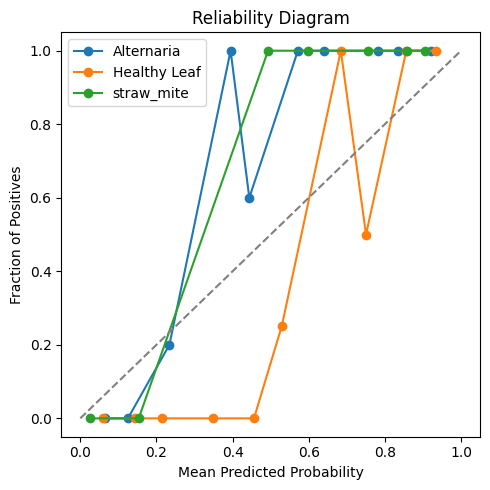


TTA Evaluation:
              precision    recall  f1-score   support

  Alternaria       0.97      0.89      0.93        37
Healthy Leaf       0.88      0.97      0.92        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.95        99
   macro avg       0.95      0.95      0.95        99
weighted avg       0.95      0.95      0.95        99

Confusion Matrix:
 [[33  4  0]
 [ 1 30  0]
 [ 0  0 31]]


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import random
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Seeding for Reproducibility ---
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths & Class Names ---
data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_pretrained.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']

# --- Mixup ---
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- Data Loaders with Balanced Sampling ---
def get_loaders(batch_size=32):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)

    # Balanced sampling
    class_sample_count = np.array([len(np.where(np.array(train_ds.targets)==t)[0]) for t in np.unique(train_ds.targets)])
    weights = 1. / class_sample_count
    samples_weights = weights[train_ds.targets]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

# --- Model Definition ---
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        resnet = models.resnet50(pretrained=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        checkpoint = torch.load(pretrained_path, map_location="cpu")
        self.backbone.load_state_dict(checkpoint['backbone'])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes))
    def forward(self, x):
        x = self.backbone(x).flatten(1)
        return self.classifier(x)

# --- Training/Evaluation Functions ---
def train_epoch(model, loader, criterion, optimizer, use_mixup=True, mixup_alpha=0.4):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += outputs.argmax(1).eq(labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return total_loss / len(loader.dataset), correct / len(loader.dataset), np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- Early Stopping Helper ---
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc, model, path):
        if self.best_acc is None or val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
            torch.save(model.state_dict(), path)
            if self.verbose:
                print("Validation accuracy improved, saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# --- Main Training Loop ---
def main(epochs=25, batch_size=32, mixup_alpha=0.4):
    train_loader, val_loader, test_loader = get_loaders(batch_size)
    model = FineTuneModel(pretrained_path, num_classes=len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    early_stopper = EarlyStopping(patience=7, verbose=True)
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, use_mixup=True, mixup_alpha=mixup_alpha)
        val_loss, val_acc, _, _, _ = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        early_stopper(val_acc, model, best_model_path)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # --- Evaluation: Standard + TTA ---
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    # Evaluate on test set
    print("\nTest set results:")
    test_loss, test_acc, test_labels, test_preds, test_probs = eval_epoch(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))

    # ROC-AUC (macro, micro)
    try:
        test_labels_onehot = np.eye(len(class_names))[test_labels]
        roc_macro = roc_auc_score(test_labels_onehot, test_probs, average='macro', multi_class='ovr')
        print(f"Test ROC-AUC (macro): {roc_macro:.4f}")
    except Exception as e:
        print(f"ROC-AUC calculation failed: {e}")

    # Calibration curve (Reliability Diagram)
    def plot_reliability(y_true, y_prob, n_bins=10):
        """Plots reliability diagram (expected calibration error)."""
        from sklearn.calibration import calibration_curve
        plt.figure(figsize=(5,5))
        for i, name in enumerate(class_names):
            prob_true, prob_pred = calibration_curve((y_true==i).astype(int), y_prob[:,i], n_bins=n_bins, strategy='uniform')
            plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Reliability Diagram")
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_reliability(test_labels, test_probs)

    # --- Test-Time Augmentation (TTA) ---
    print("\nTTA Evaluation:")
    tta_transforms = [
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomRotation(15),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ColorJitter(0.3,0.3,0.3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(280), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.GaussianBlur(3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    ]
    test_ds = ImageFolder(test_dir)
    tta_probs = []
    with torch.no_grad():
        for t in tta_transforms:
            test_ds.transform = t
            loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
            probs = []
            for imgs, _ in loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                probs.append(F.softmax(outputs, dim=1).cpu().numpy())
            tta_probs.append(np.concatenate(probs))
    final_probs = np.mean(tta_probs, axis=0)
    final_preds = final_probs.argmax(axis=1)
    print(classification_report(test_ds.targets, final_preds, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(test_ds.targets, final_preds))

if __name__ == '__main__':
    main(epochs=25, batch_size=32, mixup_alpha=0.4)


Hybrid loss: Supervised Contrastive + CrossEntropy

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import random
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_pretrained.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']

def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def get_loaders(batch_size=32):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)

    class_sample_count = np.array([len(np.where(np.array(train_ds.targets)==t)[0]) for t in np.unique(train_ds.targets)])
    weights = 1. / class_sample_count
    samples_weights = weights[train_ds.targets]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, test_ds

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8

    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(batch_size, device=device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + self.eps)
        loss = -mean_log_prob_pos.mean()
        return loss

class FineTuneModel(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        resnet = models.resnet50(pretrained=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        checkpoint = torch.load(pretrained_path, map_location="cpu")
        self.backbone.load_state_dict(checkpoint['backbone'])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes))
        self.feature_layer = nn.Linear(2048, 128)

    def forward(self, x, return_features=False):
        feats = self.backbone(x).flatten(1)
        features = F.normalize(self.feature_layer(feats), dim=1)
        logits = self.classifier(feats)
        if return_features:
            return logits, features
        return logits

def train_epoch(model, loader, ce_loss_fn, supcon_loss_fn, optimizer, use_mixup=True, mixup_alpha=0.4, supcon_weight=0.5):
    model.train()
    total_loss, total_ce, total_supcon, correct = 0, 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            logits, features = model(imgs, return_features=True)
            loss_ce = mixup_criterion(ce_loss_fn, logits, y_a, y_b, lam)
            loss_supcon = supcon_loss_fn(features, labels)
            loss = (1 - supcon_weight) * loss_ce + supcon_weight * loss_supcon
            preds = logits.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            logits, features = model(imgs, return_features=True)
            loss_ce = ce_loss_fn(logits, labels)
            loss_supcon = supcon_loss_fn(features, labels)
            loss = (1 - supcon_weight) * loss_ce + supcon_weight * loss_supcon
            correct += logits.argmax(1).eq(labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_ce += loss_ce.item() * imgs.size(0)
        total_supcon += loss_supcon.item() * imgs.size(0)
    n = len(loader.dataset)
    return total_loss / n, correct / n, total_ce / n, total_supcon / n

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    n = len(loader.dataset)
    return total_loss / n, correct / n, np.array(all_labels), np.array(all_preds), np.array(all_probs)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc, model, path):
        if self.best_acc is None or val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
            torch.save(model.state_dict(), path)
            if self.verbose:
                print("Validation accuracy improved, saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Normalized Confusion Matrix (hybrid loss)')
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_roc_per_class(y_true, y_score, n_classes, class_names, save_path=None):
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        if np.sum(y_true==i) == 0: continue  # skip missing classes
        try:
            fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"ROC error for class {class_names[i]}: {e}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-class ROC Curves (hybrid loss)')
    plt.legend()
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_tta_stats(tta_probs, test_probs, class_names, save_path=None):
    mean_probs = np.mean(tta_probs, axis=0)
    var_probs = np.var(tta_probs, axis=0)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(class_names, mean_probs.mean(axis=0))
    plt.title("TTA Mean predicted probability (hybrid loss)")
    plt.subplot(1,2,2)
    plt.bar(class_names, var_probs.mean(axis=0))
    plt.title("TTA Prediction variance (hybrid loss)")
    plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.close()
    return mean_probs, var_probs

def show_tta_flip_examples(test_probs, tta_mean_probs, test_images, test_labels, final_preds, class_names, n_show=5):
    orig_preds = np.argmax(test_probs, axis=1)
    flip_idx = np.where(orig_preds != final_preds)[0]
    print(f"Found {len(flip_idx)} TTA-flip examples.")
    if len(flip_idx) == 0:
        print("No flip examples found.")
        return
    n_show = min(n_show, len(flip_idx))
    for idx in flip_idx[:n_show]:
        img = test_images[idx]
        plt.imshow(np.transpose(img.numpy(), (1,2,0)) * 0.229 + 0.485)
        plt.title(f"True: {class_names[test_labels[idx]]}, Orig: {class_names[orig_preds[idx]]}, TTA: {class_names[final_preds[idx]]}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"tta_flip_example_{idx}_hybrid_loss.png")
        plt.close()

def plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs, train_ce_losses, train_supcon_losses):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Total')
    plt.plot(val_losses, label='Val CE')
    plt.plot(train_ce_losses, label='Train CE')
    plt.plot(train_supcon_losses, label='Train SupCon')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves (hybrid loss)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves (hybrid loss)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("loss_acc_curves_hybrid_loss.png")
    plt.close()

def save_gradcams(model, test_ds, class_names, device):
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from PIL import Image
    target_layers = [model.backbone[-1]]
    model.eval()
    cam = GradCAM(model=model, target_layers=target_layers)
    for i, cls in enumerate(class_names):
        idxs = [j for j, t in enumerate(test_ds.targets) if t == i]
        if not idxs:
            print(f"No samples for class {cls}")
            continue
        idx = random.choice(idxs)
        img, label = test_ds[idx]
        # Convert tensor to PIL image for proper transform
        img_pil = transforms.ToPILImage()(img)
        # Apply transforms that were used during test
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(i)])
        grayscale_cam = grayscale_cam[0, :]
        img_np = np.transpose(img.numpy(), (1,2,0))
        img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        plt.imshow(cam_image)
        plt.title(f"Grad-CAM: {cls} (hybrid loss)")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"gradcam_{cls}_hybrid_loss.png")
        plt.close()

def main(epochs=25, batch_size=32, mixup_alpha=0.4, supcon_weight=0.5):
    train_loader, val_loader, test_loader, test_ds = get_loaders(batch_size)
    model = FineTuneModel(pretrained_path, num_classes=len(class_names)).to(device)
    ce_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
    supcon_loss_fn = SupConLoss(temperature=0.07)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    early_stopper = EarlyStopping(patience=7, verbose=True)
    best_model_path = "best_model_hybrid_loss.pth"

    train_losses, train_accs, train_ce_losses, train_supcon_losses = [], [], [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        t_loss, t_acc, t_ce, t_sup = train_epoch(
            model, train_loader, ce_loss_fn, supcon_loss_fn, optimizer,
            use_mixup=True, mixup_alpha=mixup_alpha, supcon_weight=supcon_weight)
        v_loss, v_acc, _, _, _ = eval_epoch(model, val_loader, ce_loss_fn)
        scheduler.step()
        print(f"Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}")
        train_losses.append(t_loss)
        train_accs.append(t_acc)
        train_ce_losses.append(t_ce)
        train_supcon_losses.append(t_sup)
        val_losses.append(v_loss)
        val_accs.append(v_acc)
        early_stopper(v_acc, model, best_model_path)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs, train_ce_losses, train_supcon_losses)

    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    print("\nTest set results:")
    test_loss, test_acc, test_labels, test_preds, test_probs = eval_epoch(model, test_loader, ce_loss_fn)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    plot_confusion_matrix(test_labels, test_preds, class_names, save_path="norm_confmat_hybrid_loss.png")

    try:
        test_labels_onehot = np.eye(len(class_names))[test_labels]
        roc_macro = roc_auc_score(test_labels_onehot, test_probs, average='macro', multi_class='ovr')
        print(f"Test ROC-AUC (macro): {roc_macro:.4f}")
        plot_roc_per_class(test_labels, test_probs, len(class_names), class_names, save_path="perclass_roc_hybrid_loss.png")
    except Exception as e:
        print(f"ROC-AUC calculation failed: {e}")

    def plot_reliability(y_true, y_prob, n_bins=10):
        from sklearn.calibration import calibration_curve
        plt.figure(figsize=(5,5))
        for i, name in enumerate(class_names):
            try:
                prob_true, prob_pred = calibration_curve((y_true==i).astype(int), y_prob[:,i], n_bins=n_bins, strategy='uniform')
                plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")
            except Exception as e:
                print(f"Reliability curve failed for {name}: {e}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Reliability Diagram (hybrid loss)")
        plt.legend()
        plt.tight_layout()
        plt.savefig("reliability_diagram_hybrid_loss.png")
        plt.close()
    plot_reliability(test_labels, test_probs)

    print("\nTTA Evaluation:")
    tta_transforms = [
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomRotation(15),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ColorJitter(0.3,0.3,0.3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(280), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.GaussianBlur(3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    ]
    tta_probs = []
    for t in tta_transforms:
        test_ds.transform = t
        loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
        probs = []
        with torch.no_grad():
            for imgs, _ in loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                probs.append(F.softmax(outputs, dim=1).cpu().numpy())
        tta_probs.append(np.concatenate(probs))
    tta_probs = np.array(tta_probs)
    final_probs = np.mean(tta_probs, axis=0)
    final_preds = final_probs.argmax(axis=1)
    print(classification_report(test_ds.targets, final_preds, target_names=class_names))
    plot_confusion_matrix(test_ds.targets, final_preds, class_names, save_path="tta_confmat_hybrid_loss.png")
    plot_tta_stats(tta_probs, test_probs, class_names, save_path="tta_mean_var_hybrid_loss.png")
    show_tta_flip_examples(test_probs, final_probs, [img for img, _ in test_ds], test_ds.targets, final_preds, class_names)

    print("\nRunning Grad-CAMs for each class on random test images...")
    save_gradcams(model, test_ds, class_names, device)

if __name__ == '__main__':
    main(epochs=25, batch_size=32, mixup_alpha=0.4, supcon_weight=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/25


Train Loss: 2.2743, Acc: 0.3448 | Val Loss: 1.0416, Acc: 0.3737
Validation accuracy improved, saving model.

Epoch 2/25


Train Loss: 2.2386, Acc: 0.4364 | Val Loss: 0.8677, Acc: 0.6566
Validation accuracy improved, saving model.

Epoch 3/25


Train Loss: 2.1882, Acc: 0.5017 | Val Loss: 1.0483, Acc: 0.6465
EarlyStopping counter: 1 / 7

Epoch 4/25


Train Loss: 2.1720, Acc: 0.5604 | Val Loss: 0.9984, Acc: 0.7879
Validation accuracy improved, saving model.

Epoch 5/25


Train Loss: 2.1784, Acc: 0.5750 | Val Loss: 0.6242, Acc: 0.8384
Validation accuracy improved, saving model.

Epoch 6/25


Train Loss: 2.1116, Acc: 0.6574 | Val Loss: 0.5287, Acc: 0.8182
EarlyStopping counter: 1 / 7

Epoch 7/25


Train Loss: 2.1529, Acc: 0.5761 | Val Loss: 0.5526, Acc: 0.8586
Validation accuracy improved, saving model.

Epoch 8/25


Train Loss: 2.1647, Acc: 0.5483 | Val Loss: 0.7659, Acc: 0.7374
EarlyStopping counter: 1 / 7

Epoch 9/25


Train Loss: 2.1245, Acc: 0.6030 | Val Loss: 1.1365, Acc: 0.7576
EarlyStopping counter: 2 / 7

Epoch 10/25


Train Loss: 2.1413, Acc: 0.5952 | Val Loss: 0.6063, Acc: 0.7980
EarlyStopping counter: 3 / 7

Epoch 11/25


Train Loss: 2.0790, Acc: 0.6868 | Val Loss: 0.4783, Acc: 0.8485
EarlyStopping counter: 4 / 7

Epoch 12/25


Train Loss: 2.1212, Acc: 0.6359 | Val Loss: 0.5170, Acc: 0.8384
EarlyStopping counter: 5 / 7

Epoch 13/25


Train Loss: 2.0870, Acc: 0.6703 | Val Loss: 0.4726, Acc: 0.8687
Validation accuracy improved, saving model.

Epoch 14/25


Train Loss: 2.1324, Acc: 0.6610 | Val Loss: 0.4566, Acc: 0.9091
Validation accuracy improved, saving model.

Epoch 15/25


Train Loss: 2.1050, Acc: 0.6499 | Val Loss: 0.5466, Acc: 0.7980
EarlyStopping counter: 1 / 7

Epoch 16/25


Train Loss: 2.0790, Acc: 0.6306 | Val Loss: 0.5334, Acc: 0.8182
EarlyStopping counter: 2 / 7

Epoch 17/25


Train Loss: 2.0920, Acc: 0.6482 | Val Loss: 0.4640, Acc: 0.8788
EarlyStopping counter: 3 / 7

Epoch 18/25


Train Loss: 2.1113, Acc: 0.6381 | Val Loss: 0.4767, Acc: 0.8788
EarlyStopping counter: 4 / 7

Epoch 19/25


Train Loss: 2.1032, Acc: 0.6231 | Val Loss: 0.4494, Acc: 0.9091
EarlyStopping counter: 5 / 7

Epoch 20/25


Train Loss: 2.0712, Acc: 0.6792 | Val Loss: 0.4448, Acc: 0.8788
EarlyStopping counter: 6 / 7

Epoch 21/25


Train Loss: 2.1239, Acc: 0.6265 | Val Loss: 0.4493, Acc: 0.8990
EarlyStopping counter: 7 / 7
Early stopping triggered.

Test set results:


Test Loss: 0.3602, Test Acc: 0.9697
              precision    recall  f1-score   support

  Alternaria       1.00      0.92      0.96        37
Healthy Leaf       0.94      1.00      0.97        31
  straw_mite       0.97      1.00      0.98        31

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99

Test ROC-AUC (macro): 0.9969

TTA Evaluation:
              precision    recall  f1-score   support

  Alternaria       0.94      0.86      0.90        37
Healthy Leaf       0.88      0.94      0.91        31
  straw_mite       0.97      1.00      0.98        31

    accuracy                           0.93        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.93      0.93      0.93        99

Found 4 TTA-flip examples.

Running Grad-CAMs for each class on random test images...


CBAM SIMSIAM RESNET 

In [10]:
%%writefile cbam_resnet.py
import torch
import torch.nn as nn
from torchvision.models.resnet import ResNet, Bottleneck

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAMBottleneck(Bottleneck):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        planes = self.conv3.out_channels
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

def cbam_resnet50(**kwargs):
    model = ResNet(CBAMBottleneck, [3, 4, 6, 3], **kwargs)
    return model

Writing cbam_resnet.py


In [2]:
%%writefile simsiam_cbam_pretrain.py
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import RandAugment
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from cbam_resnet import cbam_resnet50

# --- Seed for reproducibility ---
def seed_all(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all()

# --- SimSiam Model ---
class MLPHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=2048, out_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim, bias=False),
            nn.BatchNorm1d(out_dim, affine=False)
        )
    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=512, out_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class SimSiam(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projector = MLPHead()
        self.predictor = PredictionHead()
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                m.requires_grad_(False)
    def _forward_backbone(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)
    def forward(self, x1, x2):
        z1 = self.projector(self._forward_backbone(x1))
        z2 = self.projector(self._forward_backbone(x2))
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)
        return p1, p2, z1.detach(), z2.detach()

# --- Dataset ---
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
                          if fname.lower().endswith(('png', 'jpg', 'jpeg'))]
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert('RGB')
        return self.transform(img), self.transform(img)

# --- Loss ---
def negative_cosine_similarity(p, z):
    p = nn.functional.normalize(p, dim=1)
    z = nn.functional.normalize(z, dim=1)
    return -(p * z).sum(dim=1).mean()

# --- Pretraining function ---
def pretrain(root_path="/kaggle/input/minida/mini_output1/pretrain",
             checkpoint_dir="/kaggle/working/",
             epochs=200, batch_size=32, accumulation_steps=4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(checkpoint_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "logs_cbam"))

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = UnlabeledDataset(root_path, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

    model = SimSiam().to(device)
    base_lr = 0.05 * batch_size / 256
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()
        for idx, (x1, x2) in enumerate(dataloader):
            x1, x2 = x1.to(device), x2.to(device)
            p1, p2, z1, z2 = model(x1, x2)
            loss = 0.5 * (negative_cosine_similarity(p1, z2) + negative_cosine_similarity(p2, z1))
            loss.backward()
            if (idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        scheduler.step()
        writer.add_scalar("Loss/train", avg_loss, epoch)

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"simsiam_cbam_epoch_{epoch+1}.pth"))

        print(f"Epoch [{epoch+1}/{epochs}] Avg Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), os.path.join(checkpoint_dir, "simsiam_cbam_pretrained_final.pth"))
    print("Pretraining complete!")

if __name__ == '__main__':
    pretrain()


Overwriting simsiam_cbam_pretrain.py


In [ ]:
!python simsiam_cbam_pretrain.py

**CBAM-ResNet fine-tuning**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import RandAugment
from tqdm import tqdm
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc

from cbam_resnet import cbam_resnet50  # Make sure this is in your path

# ---------- SEED & DEVICE ----------
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- PATHS & CLASSES ----------
data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_cbam_pretrained_final.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']
num_classes = len(class_names)

# ---------- MIXUP ----------
def mixup_data(x, y, alpha=0.3):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------- DATALOADERS ----------
def get_loaders(batch_size=32):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)

    class_counts = np.bincount(train_ds.targets)
    weights = 1. / class_counts[train_ds.targets]
    sampler = WeightedRandomSampler(weights, len(train_ds), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader, test_ds

# ---------- MODEL ----------
class FineTuneCBAM(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        backbone = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        ckpt = torch.load(pretrained_path, map_location=device)
        if 'backbone' in ckpt:
            self.backbone.load_state_dict(ckpt['backbone'], strict=False)
        else:
            self.backbone.load_state_dict(ckpt, strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x).flatten(1)
        return self.classifier(x)

# ---------- LR SCHEDULER ----------
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
def get_scheduler(optimizer, total_epochs, warmup_epochs=5):
    warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs-warmup_epochs)
    return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# ---------- TRAINING & EVAL ----------
def train_epoch(model, loader, criterion, optimizer, use_mixup=True, mixup_alpha=0.3):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += outputs.argmax(1).eq(labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, all_labels, all_probs = 0, 0, [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), acc, np.array(all_labels), np.array(all_probs)

# ---------- EARLY STOPPING ----------
class EarlyStopping:
    def __init__(self, patience=8, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.best_state = None
        self.verbose = verbose
    def __call__(self, val_acc, model):
        if (self.best_acc is None) or (val_acc > self.best_acc):
            self.best_acc = val_acc
            self.best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            self.counter = 0
            if self.verbose: print("Validation accuracy improved, saving best state.")
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                return True
            return False

# ---------- PLOTTING ----------
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Normalized Confusion Matrix (CBAM)')
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_roc_per_class(y_true, y_score, n_classes, class_names, save_path=None):
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        if np.sum(y_true==i) == 0: continue
        try:
            fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"ROC error for class {class_names[i]}: {e}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-class ROC Curves (CBAM)')
    plt.legend()
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_reliability(y_true, y_prob, n_bins=10):
    from sklearn.calibration import calibration_curve
    plt.figure(figsize=(5,5))
    for i, name in enumerate(class_names):
        try:
            prob_true, prob_pred = calibration_curve((y_true==i).astype(int), y_prob[:,i], n_bins=n_bins, strategy='uniform')
            plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")
        except Exception as e:
            print(f"Reliability curve failed for {name}: {e}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Reliability Diagram (CBAM)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("reliability_diagram_cbam.png")
    plt.close()

def plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves (CBAM)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves (CBAM)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("loss_acc_curves_cbam.png")
    plt.close()

# ---------- TTA ----------
def tta_eval(model, test_ds, batch_size, class_names):
    tta_transforms = [
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomVerticalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomRotation(15),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(280), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.GaussianBlur(3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    ]
    tta_probs = []
    model.eval()
    for t in tta_transforms:
        test_ds.transform = t
        loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
        preds = []
        with torch.no_grad():
            for imgs, _ in loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        tta_probs.append(np.concatenate(preds))
    tta_probs = np.array(tta_probs)
    mean_probs = np.mean(tta_probs, axis=0)
    final_preds = np.argmax(mean_probs, axis=1)
    return mean_probs, final_preds

# ---------- MAIN ----------
def main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3):
    train_loader, val_loader, test_loader, test_ds = get_loaders(batch_size)
    model = FineTuneCBAM(pretrained_path, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = get_scheduler(optimizer, epochs, warmup_epochs=5)
    early_stopper = EarlyStopping(patience=patience)

    # (OPTIONAL) Freeze backbone for warmup
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(epochs):
        if epoch == 5:
            for param in model.backbone.parameters():
                param.requires_grad = True
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, use_mixup=True, mixup_alpha=mixup_alpha)
        v_loss, v_acc, _, _ = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc)
        val_losses.append(v_loss)
        val_accs.append(v_acc)
        print(f"Epoch {epoch+1}: Train Loss {t_loss:.4f}, Acc {t_acc:.4f} | Val Loss {v_loss:.4f}, Acc {v_acc:.4f}")
        if early_stopper(v_acc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs)
    model.load_state_dict(early_stopper.best_state)

    print("\nTest set results (CBAM):")
    test_loss, test_acc, test_labels, test_probs = eval_epoch(model, test_loader, criterion)
    test_preds = np.argmax(test_probs, axis=1)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    plot_confusion_matrix(test_labels, test_preds, class_names, save_path="cbam_norm_confmat.png")

    try:
        test_labels_onehot = np.eye(num_classes)[test_labels]
        roc_macro = roc_auc_score(test_labels_onehot, test_probs, average='macro', multi_class='ovr')
        print(f"Test ROC-AUC (macro): {roc_macro:.4f}")
        plot_roc_per_class(test_labels, test_probs, num_classes, class_names, save_path="cbam_perclass_roc.png")
    except Exception as e:
        print(f"ROC-AUC calculation failed: {e}")

    plot_reliability(test_labels, test_probs)

    # -------- TTA --------
    print("\nTest-Time Augmentation (TTA) Evaluation (CBAM):")
    mean_probs, final_preds = tta_eval(model, test_ds, batch_size, class_names)
    print(classification_report(test_ds.targets, final_preds, target_names=class_names))
    plot_confusion_matrix(test_ds.targets, final_preds, class_names, save_path="cbam_tta_confmat.png")

if __name__ == '__main__':
    main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3)


Epoch 1: Train Loss 1.0797, Acc 0.4428 | Val Loss 1.1021, Acc 0.3131
Validation accuracy improved, saving best state.


Epoch 2: Train Loss 1.0514, Acc 0.4315 | Val Loss 1.1091, Acc 0.3131
EarlyStopping counter: 1 / 8


Epoch 3: Train Loss 1.0452, Acc 0.4233 | Val Loss 1.0132, Acc 0.4747
Validation accuracy improved, saving best state.


Epoch 4: Train Loss 1.0478, Acc 0.4563 | Val Loss 0.9460, Acc 0.6869
Validation accuracy improved, saving best state.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss 1.0646, Acc 0.4371 | Val Loss 0.9650, Acc 0.6162
EarlyStopping counter: 1 / 8


Epoch 6: Train Loss 1.0260, Acc 0.4961 | Val Loss 0.8190, Acc 0.6869
EarlyStopping counter: 2 / 8


Epoch 7: Train Loss 0.9878, Acc 0.5293 | Val Loss 0.7635, Acc 0.7273
Validation accuracy improved, saving best state.


Epoch 8: Train Loss 0.9395, Acc 0.5544 | Val Loss 0.5978, Acc 0.8384
Validation accuracy improved, saving best state.


Epoch 9: Train Loss 0.9318, Acc 0.5686 | Val Loss 0.5133, Acc 0.8788
Validation accuracy improved, saving best state.


Epoch 10: Train Loss 0.8408, Acc 0.6399 | Val Loss 0.4725, Acc 0.8384
EarlyStopping counter: 1 / 8


Epoch 11: Train Loss 0.8235, Acc 0.6594 | Val Loss 0.5732, Acc 0.7778
EarlyStopping counter: 2 / 8


Epoch 12: Train Loss 0.8280, Acc 0.6499 | Val Loss 0.4551, Acc 0.8485
EarlyStopping counter: 3 / 8


Epoch 13: Train Loss 0.8032, Acc 0.6788 | Val Loss 0.4415, Acc 0.8889
Validation accuracy improved, saving best state.


Epoch 14: Train Loss 0.7189, Acc 0.7159 | Val Loss 0.4325, Acc 0.8889
EarlyStopping counter: 1 / 8


Epoch 15: Train Loss 0.8371, Acc 0.6578 | Val Loss 0.4500, Acc 0.8990
Validation accuracy improved, saving best state.


Epoch 16: Train Loss 0.7392, Acc 0.7146 | Val Loss 0.4594, Acc 0.8182
EarlyStopping counter: 1 / 8


Epoch 17: Train Loss 0.8212, Acc 0.6590 | Val Loss 0.4256, Acc 0.8990
EarlyStopping counter: 2 / 8


Epoch 18: Train Loss 0.7327, Acc 0.7387 | Val Loss 0.4640, Acc 0.8283
EarlyStopping counter: 3 / 8


Epoch 19: Train Loss 0.7776, Acc 0.6827 | Val Loss 0.3873, Acc 0.9091
Validation accuracy improved, saving best state.


Epoch 20: Train Loss 0.7947, Acc 0.7034 | Val Loss 0.3819, Acc 0.9293
Validation accuracy improved, saving best state.


Epoch 21: Train Loss 0.6738, Acc 0.7706 | Val Loss 0.4699, Acc 0.8485
EarlyStopping counter: 1 / 8


Epoch 22: Train Loss 0.7487, Acc 0.7139 | Val Loss 0.3828, Acc 0.8889
EarlyStopping counter: 2 / 8


Epoch 23: Train Loss 0.7398, Acc 0.7155 | Val Loss 0.4218, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 24: Train Loss 0.7984, Acc 0.6800 | Val Loss 0.3936, Acc 0.9091
EarlyStopping counter: 4 / 8


Epoch 25: Train Loss 0.7769, Acc 0.6762 | Val Loss 0.4109, Acc 0.9091
EarlyStopping counter: 5 / 8


Epoch 26: Train Loss 0.7512, Acc 0.7150 | Val Loss 0.4405, Acc 0.8788
EarlyStopping counter: 6 / 8


Epoch 27: Train Loss 0.7297, Acc 0.7033 | Val Loss 0.3844, Acc 0.8788
EarlyStopping counter: 7 / 8


Epoch 28: Train Loss 0.6994, Acc 0.7555 | Val Loss 0.3401, Acc 0.9495
Validation accuracy improved, saving best state.


Epoch 29: Train Loss 0.7122, Acc 0.7373 | Val Loss 0.3407, Acc 0.9394
EarlyStopping counter: 1 / 8


Epoch 30: Train Loss 0.7144, Acc 0.7273 | Val Loss 0.3748, Acc 0.9091
EarlyStopping counter: 2 / 8


Epoch 31: Train Loss 0.6796, Acc 0.7512 | Val Loss 0.3562, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 32: Train Loss 0.7132, Acc 0.7086 | Val Loss 0.3366, Acc 0.9293
EarlyStopping counter: 4 / 8


Epoch 33: Train Loss 0.6956, Acc 0.7399 | Val Loss 0.3485, Acc 0.9192
EarlyStopping counter: 5 / 8


Epoch 34: Train Loss 0.6700, Acc 0.7500 | Val Loss 0.3634, Acc 0.9091
EarlyStopping counter: 6 / 8


Epoch 35: Train Loss 0.7068, Acc 0.7411 | Val Loss 0.3515, Acc 0.9192
EarlyStopping counter: 7 / 8


Epoch 36: Train Loss 0.6281, Acc 0.7872 | Val Loss 0.3346, Acc 0.9293
EarlyStopping counter: 8 / 8
Early stopping at epoch 36

Test set results (CBAM):


Test Loss: 0.2851, Test Acc: 0.9697
              precision    recall  f1-score   support

  Alternaria       1.00      0.92      0.96        37
Healthy Leaf       0.91      1.00      0.95        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99

Test ROC-AUC (macro): 0.9982

Test-Time Augmentation (TTA) Evaluation (CBAM):
              precision    recall  f1-score   support

  Alternaria       0.97      0.95      0.96        37
Healthy Leaf       0.94      1.00      0.97        31
  straw_mite       1.00      0.97      0.98        31

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



**hybrid SupCon+CE**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import RandAugment
from tqdm import tqdm
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc

from cbam_resnet import cbam_resnet50

# ---------- SEED & DEVICE ----------
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- PATHS & CLASSES ----------
data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_cbam_pretrained_final.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']
num_classes = len(class_names)

# ---------- MIXUP ----------
def mixup_data(x, y, alpha=0.3):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------- SUPERVISED CONTRASTIVE LOSS ----------
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8
    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(batch_size, device=device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + self.eps)
        loss = -mean_log_prob_pos.mean()
        return loss

# ---------- DATALOADERS ----------
def get_loaders(batch_size=32):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)

    class_counts = np.bincount(train_ds.targets)
    weights = 1. / class_counts[train_ds.targets]
    sampler = WeightedRandomSampler(weights, len(train_ds), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader, test_ds

# ---------- MODEL ----------
class FineTuneCBAM(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        backbone = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        ckpt = torch.load(pretrained_path, map_location=device)
        if 'backbone' in ckpt:
            self.backbone.load_state_dict(ckpt['backbone'], strict=False)
        else:
            self.backbone.load_state_dict(ckpt, strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        self.feature_layer = nn.Linear(2048, 128)  # For SupCon

    def forward(self, x, return_features=False):
        feats = self.backbone(x).flatten(1)
        features = F.normalize(self.feature_layer(feats), dim=1)
        logits = self.classifier(feats)
        if return_features:
            return logits, features
        return logits

# ---------- LR SCHEDULER ----------
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
def get_scheduler(optimizer, total_epochs, warmup_epochs=5):
    warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs-warmup_epochs)
    return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# ---------- TRAINING & EVAL ----------
def train_epoch(model, loader, ce_loss_fn, supcon_loss_fn, optimizer,
                use_mixup=True, mixup_alpha=0.3, supcon_weight=0.5):
    model.train()
    total_loss, total_ce, total_supcon, correct = 0, 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            logits, features = model(imgs, return_features=True)
            loss_ce = mixup_criterion(ce_loss_fn, logits, y_a, y_b, lam)
            loss_supcon = supcon_loss_fn(features, labels)
            loss = (1 - supcon_weight) * loss_ce + supcon_weight * loss_supcon
            preds = logits.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            logits, features = model(imgs, return_features=True)
            loss_ce = ce_loss_fn(logits, labels)
            loss_supcon = supcon_loss_fn(features, labels)
            loss = (1 - supcon_weight) * loss_ce + supcon_weight * loss_supcon
            correct += logits.argmax(1).eq(labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_ce += loss_ce.item() * imgs.size(0)
        total_supcon += loss_supcon.item() * imgs.size(0)
    n = len(loader.dataset)
    return total_loss / n, correct / n, total_ce / n, total_supcon / n

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, all_labels, all_probs = 0, 0, [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), acc, np.array(all_labels), np.array(all_probs)

# ---------- EARLY STOPPING ----------
class EarlyStopping:
    def __init__(self, patience=8, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.best_state = None
        self.verbose = verbose
    def __call__(self, val_acc, model):
        if (self.best_acc is None) or (val_acc > self.best_acc):
            self.best_acc = val_acc
            self.best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            self.counter = 0
            if self.verbose: print("Validation accuracy improved, saving best state.")
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                return True
            return False

# ---------- PLOTTING ----------
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Normalized Confusion Matrix (CBAM)')
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_roc_per_class(y_true, y_score, n_classes, class_names, save_path=None):
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        if np.sum(y_true==i) == 0: continue
        try:
            fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"ROC error for class {class_names[i]}: {e}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Per-class ROC Curves (CBAM)')
    plt.legend()
    if save_path: plt.savefig(save_path)
    plt.close()

def plot_reliability(y_true, y_prob, n_bins=10):
    from sklearn.calibration import calibration_curve
    plt.figure(figsize=(5,5))
    for i, name in enumerate(class_names):
        try:
            prob_true, prob_pred = calibration_curve((y_true==i).astype(int), y_prob[:,i], n_bins=n_bins, strategy='uniform')
            plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")
        except Exception as e:
            print(f"Reliability curve failed for {name}: {e}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Reliability Diagram (CBAM)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("reliability_diagram_cbam.png")
    plt.close()

def plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs, train_ce_losses, train_supcon_losses):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Total')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(train_ce_losses, label='Train CE')
    plt.plot(train_supcon_losses, label='Train SupCon')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves (CBAM Hybrid)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves (CBAM Hybrid)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("loss_acc_curves_cbam_hybrid.png")
    plt.close()

# ---------- TTA ----------
def tta_eval(model, test_ds, batch_size, class_names):
    tta_transforms = [
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomVerticalFlip(1.0),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomRotation(15),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(280), transforms.CenterCrop(224), transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.GaussianBlur(3),
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    ]
    tta_probs = []
    model.eval()
    for t in tta_transforms:
        test_ds.transform = t
        loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
        preds = []
        with torch.no_grad():
            for imgs, _ in loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        tta_probs.append(np.concatenate(preds))
    tta_probs = np.array(tta_probs)
    mean_probs = np.mean(tta_probs, axis=0)
    final_preds = np.argmax(mean_probs, axis=1)
    return mean_probs, final_preds

# ---------- MAIN ----------
def main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3, supcon_weight=0.5):
    train_loader, val_loader, test_loader, test_ds = get_loaders(batch_size)
    model = FineTuneCBAM(pretrained_path, num_classes=num_classes).to(device)
    ce_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
    supcon_loss_fn = SupConLoss(temperature=0.07)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = get_scheduler(optimizer, epochs, warmup_epochs=5)
    early_stopper = EarlyStopping(patience=patience)

    # (OPTIONAL) Freeze backbone for warmup
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    for param in model.feature_layer.parameters():
        param.requires_grad = True

    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    train_ce_losses, train_supcon_losses = [], []

    for epoch in range(epochs):
        if epoch == 5:
            for param in model.backbone.parameters():
                param.requires_grad = True
        t_loss, t_acc, t_ce, t_sup = train_epoch(
            model, train_loader, ce_loss_fn, supcon_loss_fn, optimizer,
            use_mixup=True, mixup_alpha=mixup_alpha, supcon_weight=supcon_weight)
        v_loss, v_acc, _, _ = eval_epoch(model, val_loader, ce_loss_fn)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc)
        train_ce_losses.append(t_ce)
        train_supcon_losses.append(t_sup)
        val_losses.append(v_loss)
        val_accs.append(v_acc)
        print(f"Epoch {epoch+1}: Train Loss {t_loss:.4f}, Acc {t_acc:.4f} | Val Loss {v_loss:.4f}, Acc {v_acc:.4f}")
        if early_stopper(v_acc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs, train_ce_losses, train_supcon_losses)
    model.load_state_dict(early_stopper.best_state)

    print("\nTest set results (CBAM Hybrid):")
    test_loss, test_acc, test_labels, test_probs = eval_epoch(model, test_loader, ce_loss_fn)
    test_preds = np.argmax(test_probs, axis=1)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    plot_confusion_matrix(test_labels, test_preds, class_names, save_path="cbam_norm_confmat_hybrid.png")

    try:
        test_labels_onehot = np.eye(num_classes)[test_labels]
        roc_macro = roc_auc_score(test_labels_onehot, test_probs, average='macro', multi_class='ovr')
        print(f"Test ROC-AUC (macro): {roc_macro:.4f}")
        plot_roc_per_class(test_labels, test_probs, num_classes, class_names, save_path="cbam_perclass_roc_hybrid.png")
    except Exception as e:
        print(f"ROC-AUC calculation failed: {e}")

    plot_reliability(test_labels, test_probs)

    # -------- TTA --------
    print("\nTest-Time Augmentation (TTA) Evaluation (CBAM Hybrid):")
    mean_probs, final_preds = tta_eval(model, test_ds, batch_size, class_names)
    print(classification_report(test_ds.targets, final_preds, target_names=class_names))
    plot_confusion_matrix(test_ds.targets, final_preds, class_names, save_path="cbam_tta_confmat_hybrid.png")

if __name__ == '__main__':
    main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3, supcon_weight=0.5)


Epoch 1: Train Loss 2.2487, Acc 0.3898 | Val Loss 1.1088, Acc 0.3131
Validation accuracy improved, saving best state.


Epoch 2: Train Loss 2.2073, Acc 0.4732 | Val Loss 1.1009, Acc 0.3131
EarlyStopping counter: 1 / 8


Epoch 3: Train Loss 2.1854, Acc 0.4149 | Val Loss 1.0241, Acc 0.4646
Validation accuracy improved, saving best state.


Epoch 4: Train Loss 2.1509, Acc 0.3909 | Val Loss 0.9630, Acc 0.5556
Validation accuracy improved, saving best state.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss 2.1198, Acc 0.4880 | Val Loss 0.9547, Acc 0.5051
EarlyStopping counter: 1 / 8


Epoch 6: Train Loss 2.2027, Acc 0.4493 | Val Loss 0.9060, Acc 0.5859
Validation accuracy improved, saving best state.


Epoch 7: Train Loss 2.1879, Acc 0.4928 | Val Loss 0.8403, Acc 0.6465
Validation accuracy improved, saving best state.


Epoch 8: Train Loss 2.1510, Acc 0.5059 | Val Loss 0.7801, Acc 0.7677
Validation accuracy improved, saving best state.


Epoch 9: Train Loss 2.1323, Acc 0.5324 | Val Loss 0.7574, Acc 0.7273
EarlyStopping counter: 1 / 8


Epoch 10: Train Loss 2.1112, Acc 0.5755 | Val Loss 0.7450, Acc 0.6970
EarlyStopping counter: 2 / 8


Epoch 11: Train Loss 2.1601, Acc 0.5789 | Val Loss 0.6835, Acc 0.7273
EarlyStopping counter: 3 / 8


Epoch 12: Train Loss 2.1311, Acc 0.5866 | Val Loss 0.5978, Acc 0.8384
Validation accuracy improved, saving best state.


Epoch 13: Train Loss 2.1179, Acc 0.6101 | Val Loss 0.5575, Acc 0.8081
EarlyStopping counter: 1 / 8


Epoch 14: Train Loss 2.0786, Acc 0.6883 | Val Loss 0.4622, Acc 0.8889
Validation accuracy improved, saving best state.


Epoch 15: Train Loss 2.0899, Acc 0.6630 | Val Loss 0.4747, Acc 0.8283
EarlyStopping counter: 1 / 8


Epoch 16: Train Loss 2.0270, Acc 0.6823 | Val Loss 0.4400, Acc 0.8889
EarlyStopping counter: 2 / 8


Epoch 17: Train Loss 2.0749, Acc 0.6422 | Val Loss 0.4603, Acc 0.8283
EarlyStopping counter: 3 / 8


Epoch 18: Train Loss 2.0704, Acc 0.6573 | Val Loss 0.4909, Acc 0.8586
EarlyStopping counter: 4 / 8


Epoch 19: Train Loss 2.0773, Acc 0.6651 | Val Loss 0.4470, Acc 0.8788
EarlyStopping counter: 5 / 8


Epoch 20: Train Loss 2.0559, Acc 0.6503 | Val Loss 0.4231, Acc 0.9192
Validation accuracy improved, saving best state.


Epoch 21: Train Loss 2.0119, Acc 0.7370 | Val Loss 0.4326, Acc 0.8990
EarlyStopping counter: 1 / 8


Epoch 22: Train Loss 2.0867, Acc 0.6377 | Val Loss 0.4136, Acc 0.8889
EarlyStopping counter: 2 / 8


Epoch 23: Train Loss 2.0443, Acc 0.6928 | Val Loss 0.4408, Acc 0.9293
Validation accuracy improved, saving best state.


Epoch 24: Train Loss 2.0399, Acc 0.6767 | Val Loss 0.4642, Acc 0.8485
EarlyStopping counter: 1 / 8


Epoch 25: Train Loss 1.9983, Acc 0.6738 | Val Loss 0.4130, Acc 0.9192
EarlyStopping counter: 2 / 8


Epoch 26: Train Loss 2.0241, Acc 0.6965 | Val Loss 0.4057, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 27: Train Loss 1.9852, Acc 0.6989 | Val Loss 0.4227, Acc 0.9091
EarlyStopping counter: 4 / 8


Epoch 28: Train Loss 1.9733, Acc 0.7095 | Val Loss 0.3969, Acc 0.9091
EarlyStopping counter: 5 / 8


Epoch 29: Train Loss 2.0262, Acc 0.6961 | Val Loss 0.3916, Acc 0.9192
EarlyStopping counter: 6 / 8


Epoch 30: Train Loss 1.9875, Acc 0.7056 | Val Loss 0.3999, Acc 0.8889
EarlyStopping counter: 7 / 8


Epoch 31: Train Loss 1.9295, Acc 0.7617 | Val Loss 0.3832, Acc 0.9394
Validation accuracy improved, saving best state.


Epoch 32: Train Loss 1.9527, Acc 0.7137 | Val Loss 0.3812, Acc 0.9293
EarlyStopping counter: 1 / 8


Epoch 33: Train Loss 1.9037, Acc 0.7407 | Val Loss 0.3880, Acc 0.9293
EarlyStopping counter: 2 / 8


Epoch 34: Train Loss 1.9424, Acc 0.7320 | Val Loss 0.3910, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 35: Train Loss 1.9574, Acc 0.7187 | Val Loss 0.3765, Acc 0.9394
EarlyStopping counter: 4 / 8


Epoch 36: Train Loss 1.8872, Acc 0.7782 | Val Loss 0.3792, Acc 0.9394
EarlyStopping counter: 5 / 8


Epoch 37: Train Loss 1.8645, Acc 0.7565 | Val Loss 0.3805, Acc 0.9192
EarlyStopping counter: 6 / 8


Epoch 38: Train Loss 1.9698, Acc 0.7004 | Val Loss 0.3763, Acc 0.9293
EarlyStopping counter: 7 / 8


Epoch 39: Train Loss 1.9289, Acc 0.7224 | Val Loss 0.3786, Acc 0.9293
EarlyStopping counter: 8 / 8
Early stopping at epoch 39

Test set results (CBAM Hybrid):


Test Loss: 0.3125, Test Acc: 0.9596
              precision    recall  f1-score   support

  Alternaria       1.00      0.89      0.94        37
Healthy Leaf       0.89      1.00      0.94        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.96        99
   macro avg       0.96      0.96      0.96        99
weighted avg       0.96      0.96      0.96        99

Test ROC-AUC (macro): 0.9988

Test-Time Augmentation (TTA) Evaluation (CBAM Hybrid):
              precision    recall  f1-score   support

  Alternaria       0.97      0.89      0.93        37
Healthy Leaf       0.88      0.97      0.92        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.95        99
   macro avg       0.95      0.95      0.95        99
weighted avg       0.95      0.95      0.95        99



**fine-tuning training pipeline with Gaussian noise and Salt and Pepper noise**

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import RandAugment
from tqdm import tqdm
import numpy as np
import random
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

from cbam_resnet import cbam_resnet50

# --- Reproducibility ---
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths and Classes ---
data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_cbam_pretrained_final.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']
num_classes = len(class_names)

# --- Custom Noise Transforms ---
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean
    def __repr__(self):
        return f"AddGaussianNoise(mean={self.mean}, std={self.std})"

class AddSaltPepperNoise(object):
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob
    def __call__(self, tensor):
        c, h, w = tensor.shape
        mask = torch.rand((h, w))
        salt = (mask < self.salt_prob).float()
        pepper = (mask > 1 - self.pepper_prob).float()
        for i in range(c):
            tensor[i] = tensor[i] * (1 - salt - pepper) + salt + 0 * pepper
        return tensor
    def __repr__(self):
        return f"AddSaltPepperNoise(salt_prob={self.salt_prob}, pepper_prob={self.pepper_prob})"

# --- Mixup ---
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- Data Loader with Configurable Noise ---
def get_loaders(batch_size=32, noise_cfg=None):
    if noise_cfg is None: noise_cfg = {}
    tfms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor()
    ]
    if noise_cfg.get('use_gaussian', False):
        tfms.append(transforms.RandomApply([AddGaussianNoise(std=noise_cfg.get('gaussian_std', 0.05))], p=noise_cfg.get('gaussian_p', 1.0)))
    if noise_cfg.get('use_saltpepper', False):
        tfms.append(transforms.RandomApply([AddSaltPepperNoise(salt_prob=noise_cfg.get('salt_prob',0.01), pepper_prob=noise_cfg.get('pepper_prob',0.01))], p=noise_cfg.get('saltpepper_p',1.0)))
    tfms.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    train_transform = transforms.Compose(tfms)
    val_transform = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)
    class_counts = np.bincount(train_ds.targets)
    weights = 1. / class_counts[train_ds.targets]
    sampler = WeightedRandomSampler(weights, len(train_ds), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

# --- CBAM Fine-tune Model ---
class FineTuneCBAM(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        backbone = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        ckpt = torch.load(pretrained_path, map_location=device)
        if 'backbone' in ckpt:
            self.backbone.load_state_dict(ckpt['backbone'], strict=False)
        else:
            self.backbone.load_state_dict(ckpt, strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x).flatten(1)
        return self.classifier(x)

# --- LR Scheduler with Warmup ---
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

def get_scheduler(optimizer, total_epochs, warmup_epochs=5):
    warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# --- Training and Evaluation ---
def train_epoch(model, loader, criterion, optimizer, use_mixup=True):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, desc='Train', leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels)
        optimizer.zero_grad()
        outputs = model(imgs)
        if use_mixup:
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            loss = criterion(outputs, labels)
            correct += (outputs.argmax(1) == labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, all_labels, all_probs = 0, 0, [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Eval', leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), acc, np.array(all_labels), np.array(all_probs)

# --- Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.best_state = None
    def __call__(self, val_acc, model):
        if (self.best_acc is None) or (val_acc > self.best_acc):
            self.best_acc = val_acc
            self.best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

# --- Reliability Diagram (ECE) ---
def compute_ece(labels, probs, n_bins=10):
    """Expected Calibration Error for multi-class softmax"""
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = predictions == labels
    ece = 0.0
    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if np.any(mask):
            bin_acc = np.mean(accuracies[mask])
            bin_conf = np.mean(confidences[mask])
            ece += np.abs(bin_acc - bin_conf) * np.sum(mask) / len(probs)
    return 100 * ece  # Percentage

# --- Main Experiment Runner ---
def run_ablation_experiments(ablation_configs, epochs=50, batch_size=32, patience=10, csv_path="ablation_results.csv"):
    results = []
    for cfg in ablation_configs:
        print(f"\n==== Running: {cfg['name']} ====")
        seed_all()  # Reset seed for reproducibility
        train_loader, val_loader, test_loader = get_loaders(batch_size, noise_cfg=cfg)
        model = FineTuneCBAM(pretrained_path, num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = get_scheduler(optimizer, epochs, warmup_epochs=5)
        early_stopper = EarlyStopping(patience=patience)
        for param in model.backbone.parameters(): param.requires_grad = False
        for param in model.classifier.parameters(): param.requires_grad = True

        for epoch in range(epochs):
            if epoch == 5:  # Unfreeze backbone after warmup
                for param in model.backbone.parameters(): param.requires_grad = True
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, use_mixup=True)
            val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
            scheduler.step()
            print(f"Epoch {epoch+1}: Train {train_acc:.4f}, Val {val_acc:.4f}")
            if early_stopper(val_acc, model):
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best state
        model.load_state_dict(early_stopper.best_state)

        # ---- Final Test & Evaluation ----
        _, test_acc, labels, probs = eval_epoch(model, test_loader, criterion)
        preds = np.argmax(probs, axis=1)
        # ROC-AUC macro (one-vs-rest)
        try:
            labels_onehot = np.eye(num_classes)[labels]
            roc_macro = roc_auc_score(labels_onehot, probs, average='macro', multi_class='ovr')
        except Exception as e:
            roc_macro = None
        # ECE
        ece = compute_ece(labels, probs)
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"ROC-AUC (macro): {roc_macro:.4f}" if roc_macro else "ROC-AUC N/A")
        print(f"ECE: {ece:.2f}%")
        # Save results
        row = dict(cfg)
        row.update({
            "test_acc": test_acc,
            "roc_auc_macro": roc_macro,
            "ece": ece,
        })
        results.append(row)
        pd.DataFrame(results).to_csv(csv_path, index=False)
        print(f"Results saved to {csv_path}")
    print("\nAll ablation runs complete.")
    print(pd.DataFrame(results))
    return results

# --- Define Ablation Study Conditions ---
ablation_configs = [
    {"name": "NoNoise"},
    {"name": "GaussianOnly", "use_gaussian": True, "gaussian_std": 0.05, "gaussian_p": 1.0},
    {"name": "SaltPepperOnly", "use_saltpepper": True, "salt_prob": 0.01, "pepper_prob": 0.01, "saltpepper_p": 1.0},
    {"name": "BothNoises", "use_gaussian": True, "gaussian_std": 0.05, "gaussian_p": 1.0, "use_saltpepper": True, "salt_prob": 0.01, "pepper_prob": 0.01, "saltpepper_p": 1.0},
]

if __name__ == '__main__':
    run_ablation_experiments(ablation_configs, epochs=50, batch_size=32, patience=10)



==== Running: NoNoise ====


Epoch 1: Train 0.4464, Val 0.3131


Epoch 2: Train 0.4424, Val 0.3131


Epoch 3: Train 0.4197, Val 0.3636


Epoch 4: Train 0.4436, Val 0.7172


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train 0.4606, Val 0.6465


Epoch 6: Train 0.5252, Val 0.7374


Epoch 7: Train 0.5449, Val 0.7677


Epoch 8: Train 0.5732, Val 0.8384


Epoch 9: Train 0.5855, Val 0.8485


Epoch 10: Train 0.6835, Val 0.8485


Epoch 11: Train 0.6723, Val 0.9091


Epoch 12: Train 0.7151, Val 0.8889


Epoch 13: Train 0.6953, Val 0.8788


Epoch 14: Train 0.7013, Val 0.8687


Epoch 15: Train 0.7098, Val 0.9192


Epoch 16: Train 0.7051, Val 0.8182


Epoch 17: Train 0.7088, Val 0.8687


Epoch 18: Train 0.7235, Val 0.8384


Epoch 19: Train 0.7281, Val 0.9091


Epoch 20: Train 0.7111, Val 0.9495


Epoch 21: Train 0.7653, Val 0.8384


Epoch 22: Train 0.7803, Val 0.9293


Epoch 23: Train 0.7134, Val 0.8586


Epoch 24: Train 0.7387, Val 0.9091


Epoch 25: Train 0.7328, Val 0.9091


Epoch 26: Train 0.7194, Val 0.8485


Epoch 27: Train 0.7011, Val 0.9495


Epoch 28: Train 0.7489, Val 0.9495


Epoch 29: Train 0.7699, Val 0.9293


Epoch 30: Train 0.7423, Val 0.8889
Early stopping at epoch 30


Test Accuracy: 0.9596
ROC-AUC (macro): 0.9992
ECE: 15.68%
Results saved to ablation_results.csv

==== Running: GaussianOnly ====


Epoch 1: Train 0.4270, Val 0.3131


Epoch 2: Train 0.4421, Val 0.3131


Epoch 3: Train 0.3956, Val 0.3838


Epoch 4: Train 0.4600, Val 0.7172


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train 0.4598, Val 0.6061


Epoch 6: Train 0.4616, Val 0.7273


Epoch 7: Train 0.5562, Val 0.7677


Epoch 8: Train 0.5846, Val 0.6768


Epoch 9: Train 0.5611, Val 0.7980


Epoch 10: Train 0.6435, Val 0.8384


Epoch 11: Train 0.6600, Val 0.8687


Epoch 12: Train 0.6896, Val 0.8485


Epoch 13: Train 0.6919, Val 0.8081


Epoch 14: Train 0.7071, Val 0.8182


Epoch 15: Train 0.7316, Val 0.7879


Epoch 16: Train 0.6717, Val 0.8485


Epoch 17: Train 0.7083, Val 0.8182


Epoch 18: Train 0.7259, Val 0.7980


Epoch 19: Train 0.7310, Val 0.7677


Epoch 20: Train 0.7007, Val 0.8687


Epoch 21: Train 0.7600, Val 0.8586
Early stopping at epoch 21


Test Accuracy: 0.9293
ROC-AUC (macro): 0.9956
ECE: 19.45%
Results saved to ablation_results.csv

==== Running: SaltPepperOnly ====


Epoch 1: Train 0.4504, Val 0.3131


Epoch 2: Train 0.4199, Val 0.3131


Epoch 3: Train 0.4287, Val 0.3737


Epoch 4: Train 0.4198, Val 0.6364


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train 0.4635, Val 0.5455


Epoch 6: Train 0.4535, Val 0.6667


Epoch 7: Train 0.5350, Val 0.6263


Epoch 8: Train 0.5412, Val 0.7273


Epoch 9: Train 0.5963, Val 0.8889


Epoch 10: Train 0.6179, Val 0.7879


Epoch 11: Train 0.6398, Val 0.8889


Epoch 12: Train 0.6537, Val 0.8788


Epoch 13: Train 0.6900, Val 0.8384


Epoch 14: Train 0.6655, Val 0.6263


Epoch 15: Train 0.6947, Val 0.7980


Epoch 16: Train 0.6382, Val 0.7475


Epoch 17: Train 0.6881, Val 0.7879


Epoch 18: Train 0.7041, Val 0.7879


Epoch 19: Train 0.7009, Val 0.7677
Early stopping at epoch 19


Test Accuracy: 0.8384
ROC-AUC (macro): 0.9614
ECE: 22.08%
Results saved to ablation_results.csv

==== Running: BothNoises ====


Epoch 1: Train 0.4414, Val 0.3131


Epoch 2: Train 0.4440, Val 0.3131


Epoch 3: Train 0.4231, Val 0.3838


Epoch 4: Train 0.4768, Val 0.6465


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train 0.4423, Val 0.5556


Epoch 6: Train 0.4916, Val 0.6566


Epoch 7: Train 0.5181, Val 0.6869


Epoch 8: Train 0.5507, Val 0.7374


Epoch 9: Train 0.5409, Val 0.8182


Epoch 10: Train 0.5880, Val 0.7980


Epoch 11: Train 0.6519, Val 0.7980


Epoch 12: Train 0.7015, Val 0.7172


Epoch 13: Train 0.6640, Val 0.6970


Epoch 14: Train 0.6725, Val 0.5556


Epoch 15: Train 0.6482, Val 0.6465


Epoch 16: Train 0.6535, Val 0.5657


Epoch 17: Train 0.6710, Val 0.6768


Epoch 18: Train 0.7345, Val 0.6465


Epoch 19: Train 0.7127, Val 0.7273
Early stopping at epoch 19


Test Accuracy: 0.8889
ROC-AUC (macro): 0.9876
ECE: 30.33%
Results saved to ablation_results.csv

All ablation runs complete.
             name  test_acc  roc_auc_macro        ece use_gaussian  \
0         NoNoise  0.959596       0.999248  15.679369          NaN   
1    GaussianOnly  0.929293       0.995645  19.453843         True   
2  SaltPepperOnly  0.838384       0.961374  22.078380          NaN   
3      BothNoises  0.888889       0.987576  30.332287         True   

   gaussian_std  gaussian_p use_saltpepper  salt_prob  pepper_prob  \
0           NaN         NaN            NaN        NaN          NaN   
1          0.05         1.0            NaN        NaN          NaN   
2           NaN         NaN           True       0.01         0.01   
3          0.05         1.0           True       0.01         0.01   

   saltpepper_p  
0           NaN  
1           NaN  
2           1.0  
3           1.0  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Images after Noises

In [10]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# ---- Define noise transforms ----
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.07):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class AddSaltPepperNoise(object):
    def __init__(self, salt_prob=0.03, pepper_prob=0.03):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob
    def __call__(self, tensor):
        c, h, w = tensor.shape
        mask = torch.rand((h, w))
        salt = (mask < self.salt_prob).float()
        pepper = (mask > 1 - self.pepper_prob).float()
        for i in range(c):
            tensor[i] = tensor[i] * (1 - salt - pepper) + salt + 0 * pepper
        return tensor

to_pil = transforms.ToPILImage()

# ----- Output directory -----
output_dir = '/kaggle/working/noised_samples/'
os.makedirs(output_dir, exist_ok=True)

# ----- Dataset: one image per class -----
train_dir = '/kaggle/input/minida/mini_output1/train'
ds = ImageFolder(train_dir)
class_to_idx = ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

imgs_per_class = {}
for img_path, label in ds.samples:
    if label not in imgs_per_class:
        imgs_per_class[label] = img_path
    if len(imgs_per_class) == len(idx_to_class):
        break

# ----- Define the 4 noise pipelines -----
def no_noise_pipeline():
    return transforms.Compose([
        transforms.ToTensor()
    ])
def gaussian_pipeline():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomApply([AddGaussianNoise(std=0.07)], p=1.0)
    ])
def saltpepper_pipeline():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.03, pepper_prob=0.03)], p=1.0)
    ])
def both_pipeline():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomApply([AddGaussianNoise(std=0.07)], p=1.0),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.03, pepper_prob=0.03)], p=1.0)
    ])

pipelines = [
    ("ORIGINAL", no_noise_pipeline()),
    ("GAUSSIAN", gaussian_pipeline()),
    ("SALTPEPPER", saltpepper_pipeline()),
    ("BOTHNOISES", both_pipeline()),
]

# ----- Save all versions -----
for label, img_path in imgs_per_class.items():
    class_name = idx_to_class[label]
    orig_name = os.path.splitext(os.path.basename(img_path))[0]
    img = Image.open(img_path).convert("RGB")
    for ver_name, pipeline in pipelines:
        tensor_img = pipeline(img)
        tensor_img = tensor_img.clamp(0,1)
        out_img = to_pil(tensor_img)
        save_path = os.path.join(
            output_dir, f"{class_name}__{orig_name}_{ver_name}.png"
        )
        out_img.save(save_path)
        print(f"Saved: {save_path}")

print("All versions saved in", output_dir)


Saved: /kaggle/working/noised_samples/Alternaria__alternaria (1)_ORIGINAL.png
Saved: /kaggle/working/noised_samples/Alternaria__alternaria (1)_GAUSSIAN.png
Saved: /kaggle/working/noised_samples/Alternaria__alternaria (1)_SALTPEPPER.png
Saved: /kaggle/working/noised_samples/Alternaria__alternaria (1)_BOTHNOISES.png
Saved: /kaggle/working/noised_samples/Healthy Leaf__healthy (10)_ORIGINAL.png
Saved: /kaggle/working/noised_samples/Healthy Leaf__healthy (10)_GAUSSIAN.png
Saved: /kaggle/working/noised_samples/Healthy Leaf__healthy (10)_SALTPEPPER.png
Saved: /kaggle/working/noised_samples/Healthy Leaf__healthy (10)_BOTHNOISES.png
Saved: /kaggle/working/noised_samples/straw_mite__straw_mite (10)_ORIGINAL.png
Saved: /kaggle/working/noised_samples/straw_mite__straw_mite (10)_GAUSSIAN.png
Saved: /kaggle/working/noised_samples/straw_mite__straw_mite (10)_SALTPEPPER.png
Saved: /kaggle/working/noised_samples/straw_mite__straw_mite (10)_BOTHNOISES.png
All versions saved in /kaggle/working/noised_sam

XAI

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import RandAugment
from tqdm import tqdm
import numpy as np
import random
import os
from sklearn.metrics import classification_report, confusion_matrix

from cbam_resnet import cbam_resnet50  # Ensure this file is in your working directory

# ---------- SEED & DEVICE ----------
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- PATHS & CLASSES ----------
data_root = "/kaggle/input/minida/mini_output1"
pretrained_path = "/kaggle/working/simsiam_cbam_pretrained_final.pth"
train_dir, val_dir, test_dir = [os.path.join(data_root, x) for x in ["train", "val", "test"]]
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']
num_classes = len(class_names)

# ---------- DATALOADERS ----------
def get_loaders(batch_size=32):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = ImageFolder(train_dir, train_transform)
    val_ds = ImageFolder(val_dir, val_transform)
    test_ds = ImageFolder(test_dir, val_transform)

    class_counts = np.bincount(train_ds.targets)
    weights = 1. / class_counts[train_ds.targets]
    sampler = WeightedRandomSampler(weights, len(train_ds), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader, test_ds

# ---------- MODEL ----------
class FineTuneCBAM(nn.Module):
    def __init__(self, pretrained_path, num_classes=3):
        super().__init__()
        backbone = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        ckpt = torch.load(pretrained_path, map_location=device)
        if 'backbone' in ckpt:
            self.backbone.load_state_dict(ckpt['backbone'], strict=False)
        else:
            self.backbone.load_state_dict(ckpt, strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x).flatten(1)
        return self.classifier(x)

# ---------- LR SCHEDULER ----------
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
def get_scheduler(optimizer, total_epochs, warmup_epochs=5):
    warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs-warmup_epochs)
    return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# ---------- MIXUP ----------
def mixup_data(x, y, alpha=0.3):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------- TRAINING & EVAL ----------
def train_epoch(model, loader, criterion, optimizer, use_mixup=True, mixup_alpha=0.3):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.argmax(1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += outputs.argmax(1).eq(labels).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, all_labels, all_probs = 0, 0, [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = correct / len(loader.dataset)
    return total_loss / len(loader.dataset), acc, np.array(all_labels), np.array(all_probs)

# ---------- EARLY STOPPING ----------
class EarlyStopping:
    def __init__(self, patience=8, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.best_state = None
        self.verbose = verbose
    def __call__(self, val_acc, model):
        if (self.best_acc is None) or (val_acc > self.best_acc):
            self.best_acc = val_acc
            self.best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            self.counter = 0
            if self.verbose: print("Validation accuracy improved, saving best state.")
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                return True
            return False

# ---------- MAIN ----------
def main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3):
    train_loader, val_loader, test_loader, test_ds = get_loaders(batch_size)
    model = FineTuneCBAM(pretrained_path, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = get_scheduler(optimizer, epochs, warmup_epochs=5)
    early_stopper = EarlyStopping(patience=patience)

    # Freeze backbone for warmup
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(epochs):
        if epoch == 5:
            for param in model.backbone.parameters():
                param.requires_grad = True
        t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, use_mixup=True, mixup_alpha=mixup_alpha)
        v_loss, v_acc, _, _ = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc)
        val_losses.append(v_loss)
        val_accs.append(v_acc)
        print(f"Epoch {epoch+1}: Train Loss {t_loss:.4f}, Acc {t_acc:.4f} | Val Loss {v_loss:.4f}, Acc {v_acc:.4f}")
        if early_stopper(v_acc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # --- Always restore best state and eval before testing ---
    model.load_state_dict(early_stopper.best_state)
    model.eval()
    # --- Save model at its best state ---
    torch.save(model.state_dict(), "best_finetuned_cbam.pth")
    print("Model saved as best_finetuned_cbam.pth")

    # --- Test evaluation ---
    print("\nTest set results (CBAM):")
    test_loss, test_acc, test_labels, test_probs = eval_epoch(model, test_loader, criterion)
    test_preds = np.argmax(test_probs, axis=1)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    # (Add your plotting here as needed)

if __name__ == '__main__':
    main(epochs=40, batch_size=32, patience=8, mixup_alpha=0.3)


Epoch 1: Train Loss 1.0797, Acc 0.4428 | Val Loss 1.1021, Acc 0.3131
Validation accuracy improved, saving best state.


Epoch 2: Train Loss 1.0514, Acc 0.4315 | Val Loss 1.1091, Acc 0.3131
EarlyStopping counter: 1 / 8


Epoch 3: Train Loss 1.0452, Acc 0.4233 | Val Loss 1.0132, Acc 0.4747
Validation accuracy improved, saving best state.


Epoch 4: Train Loss 1.0478, Acc 0.4563 | Val Loss 0.9460, Acc 0.6869
Validation accuracy improved, saving best state.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss 1.0646, Acc 0.4371 | Val Loss 0.9650, Acc 0.6162
EarlyStopping counter: 1 / 8


Epoch 6: Train Loss 1.0260, Acc 0.4961 | Val Loss 0.8190, Acc 0.6869
EarlyStopping counter: 2 / 8


Epoch 7: Train Loss 0.9878, Acc 0.5293 | Val Loss 0.7635, Acc 0.7273
Validation accuracy improved, saving best state.


Epoch 8: Train Loss 0.9395, Acc 0.5544 | Val Loss 0.5978, Acc 0.8384
Validation accuracy improved, saving best state.


Epoch 9: Train Loss 0.9318, Acc 0.5686 | Val Loss 0.5133, Acc 0.8788
Validation accuracy improved, saving best state.


Epoch 10: Train Loss 0.8408, Acc 0.6399 | Val Loss 0.4725, Acc 0.8384
EarlyStopping counter: 1 / 8


Epoch 11: Train Loss 0.8235, Acc 0.6594 | Val Loss 0.5732, Acc 0.7778
EarlyStopping counter: 2 / 8


Epoch 12: Train Loss 0.8280, Acc 0.6499 | Val Loss 0.4551, Acc 0.8485
EarlyStopping counter: 3 / 8


Epoch 13: Train Loss 0.8032, Acc 0.6788 | Val Loss 0.4415, Acc 0.8889
Validation accuracy improved, saving best state.


Epoch 14: Train Loss 0.7189, Acc 0.7159 | Val Loss 0.4325, Acc 0.8889
EarlyStopping counter: 1 / 8


Epoch 15: Train Loss 0.8371, Acc 0.6578 | Val Loss 0.4500, Acc 0.8990
Validation accuracy improved, saving best state.


Epoch 16: Train Loss 0.7392, Acc 0.7146 | Val Loss 0.4594, Acc 0.8182
EarlyStopping counter: 1 / 8


Epoch 17: Train Loss 0.8212, Acc 0.6590 | Val Loss 0.4256, Acc 0.8990
EarlyStopping counter: 2 / 8


Epoch 18: Train Loss 0.7327, Acc 0.7387 | Val Loss 0.4640, Acc 0.8283
EarlyStopping counter: 3 / 8


Epoch 19: Train Loss 0.7776, Acc 0.6827 | Val Loss 0.3873, Acc 0.9091
Validation accuracy improved, saving best state.


Epoch 20: Train Loss 0.7947, Acc 0.7034 | Val Loss 0.3819, Acc 0.9293
Validation accuracy improved, saving best state.


Epoch 21: Train Loss 0.6738, Acc 0.7706 | Val Loss 0.4699, Acc 0.8485
EarlyStopping counter: 1 / 8


Epoch 22: Train Loss 0.7487, Acc 0.7139 | Val Loss 0.3828, Acc 0.8889
EarlyStopping counter: 2 / 8


Epoch 23: Train Loss 0.7398, Acc 0.7155 | Val Loss 0.4218, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 24: Train Loss 0.7984, Acc 0.6800 | Val Loss 0.3936, Acc 0.9091
EarlyStopping counter: 4 / 8


Epoch 25: Train Loss 0.7769, Acc 0.6762 | Val Loss 0.4109, Acc 0.9091
EarlyStopping counter: 5 / 8


Epoch 26: Train Loss 0.7512, Acc 0.7150 | Val Loss 0.4405, Acc 0.8788
EarlyStopping counter: 6 / 8


Epoch 27: Train Loss 0.7297, Acc 0.7033 | Val Loss 0.3844, Acc 0.8788
EarlyStopping counter: 7 / 8


Epoch 28: Train Loss 0.6994, Acc 0.7555 | Val Loss 0.3401, Acc 0.9495
Validation accuracy improved, saving best state.


Epoch 29: Train Loss 0.7122, Acc 0.7373 | Val Loss 0.3407, Acc 0.9394
EarlyStopping counter: 1 / 8


Epoch 30: Train Loss 0.7144, Acc 0.7273 | Val Loss 0.3748, Acc 0.9091
EarlyStopping counter: 2 / 8


Epoch 31: Train Loss 0.6796, Acc 0.7512 | Val Loss 0.3562, Acc 0.9192
EarlyStopping counter: 3 / 8


Epoch 32: Train Loss 0.7132, Acc 0.7086 | Val Loss 0.3366, Acc 0.9293
EarlyStopping counter: 4 / 8


Epoch 33: Train Loss 0.6956, Acc 0.7399 | Val Loss 0.3485, Acc 0.9192
EarlyStopping counter: 5 / 8


Epoch 34: Train Loss 0.6700, Acc 0.7500 | Val Loss 0.3634, Acc 0.9091
EarlyStopping counter: 6 / 8


Epoch 35: Train Loss 0.7068, Acc 0.7411 | Val Loss 0.3515, Acc 0.9192
EarlyStopping counter: 7 / 8


Epoch 36: Train Loss 0.6281, Acc 0.7872 | Val Loss 0.3346, Acc 0.9293
EarlyStopping counter: 8 / 8
Early stopping at epoch 36
Model saved as best_finetuned_cbam.pth

Test set results (CBAM):


Test Loss: 0.2851, Test Acc: 0.9697
              precision    recall  f1-score   support

  Alternaria       1.00      0.92      0.96        37
Healthy Leaf       0.91      1.00      0.95        31
  straw_mite       1.00      1.00      1.00        31

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



In [ ]:
# --- XAI-Ready Loader + GradCAMs All-in-One Cell ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# ---- Model definition (match your finetune) ----
from cbam_resnet import cbam_resnet50

class FineTuneCBAM(nn.Module):
    def __init__(self, pretrained_path=None, num_classes=3):
        super().__init__()
        backbone = cbam_resnet50(num_classes=1000)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        if pretrained_path:
            ckpt = torch.load(pretrained_path, map_location='cpu')
            if 'backbone' in ckpt:
                self.backbone.load_state_dict(ckpt['backbone'], strict=False)
            else:
                self.backbone.load_state_dict(ckpt, strict=False)
    def forward(self, x):
        x = self.backbone(x).flatten(1)
        return self.classifier(x)

# --- Load model weights (set this to your actual path if needed) ---
finetuned_ckpt_path = "best_finetuned_cbam.pth"
num_classes = 3
class_names = ['Alternaria', 'Healthy Leaf', 'straw_mite']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FineTuneCBAM(pretrained_path=None, num_classes=num_classes)
model.load_state_dict(torch.load(finetuned_ckpt_path, map_location=device))
model.to(device)
model.eval()
print("Loaded fine-tuned model.")

# --- Test dataset loader ---
test_dir = "/kaggle/input/minida/mini_output1/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])
dataset = ImageFolder(test_dir, transform=transform)
print(f"Loaded {len(dataset)} test images.")

# --- XAI classes: GradCAM, GradCAM++, LayerCAM ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):
        def fw_hook(_, __, output):
            self.activations = output.detach()
        def bw_hook(_, __, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(fw_hook)
        self.target_layer.register_full_backward_hook(bw_hook)
    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)
        weights = self.gradients.mean(dim=(2,3))[0]
        cam = torch.zeros(self.activations.shape[2:], device=input_tensor.device)
        for i, w in enumerate(weights):
            cam += w * self.activations[0, i]
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        return cam.cpu().numpy(), class_idx

class GradCAMPlusPlus(GradCAM):
    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)
        g = self.gradients
        a = self.activations
        alpha_num = g.pow(2)
        alpha_denom = 2 * g.pow(2) + (a * g.pow(3)).sum(dim=(2, 3), keepdim=True)
        alpha = alpha_num / (alpha_denom + 1e-7)
        weights = (alpha * F.relu(g)).sum(dim=(2, 3))[0]
        cam = torch.zeros(a.shape[2:], device=input_tensor.device)
        for i, w in enumerate(weights):
            cam += w * a[0, i]
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        return cam.cpu().numpy(), class_idx

class LayerCAM(GradCAM):
    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)
        cam = (self.gradients * self.activations).sum(dim=1)[0]
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        return cam.cpu().numpy(), class_idx

# --- Choose a target layer (typically last conv, but -2/-3 sometimes better) ---
target_layer = model.backbone[-1]  # You can try -2, -3 for more spatial
print("Target layer for CAM:", target_layer)

# --- Pick one sample per class ---
seen = set()
samples = []
for img, label in dataset:
    if label not in seen:
        samples.append((img, label))
        seen.add(label)
    if len(seen) == num_classes:
        break

# --- Visualize CAMs for each class ---
for img_tensor, label in samples:
    img_tensor = img_tensor.unsqueeze(0).to(device)
    # Get the original image for overlay
    original_img = inv_transform(img_tensor[0].cpu()).permute(1,2,0).numpy()
    original_img = np.clip(original_img * 255, 0, 255).astype(np.uint8)
    # Generate CAMs
    gradcam = GradCAM(model, target_layer)
    cam1, _ = gradcam.generate(img_tensor)
    gradcampp = GradCAMPlusPlus(model, target_layer)
    cam2, _ = gradcampp.generate(img_tensor)
    layercam = LayerCAM(model, target_layer)
    cam3, _ = layercam.generate(img_tensor)
    # Overlay utility
    def overlay(img, cam):
        cam = cv2.resize(cam, (224,224))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        overlayed = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
        return overlayed
    # Plot all
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(original_img)
    plt.title(f"Original\nClass: {class_names[label]}")
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(overlay(original_img, cam1))
    plt.title("GradCAM")
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(overlay(original_img, cam2))
    plt.title("GradCAM++")
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(overlay(original_img, cam3))
    plt.title("LayerCAM")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
